<a href="https://colab.research.google.com/github/shubavarma/DeepLearning/blob/main/BankNote_Authentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.4 MB/s eta 0:00:00


In [42]:
import tensorflow
import tensorflow.keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
import kerastuner as k
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
notes = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DLdatasets/BankNote_Authentication.csv")
notes

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [4]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


There are no missing values


In [5]:
notes['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

This is slightly imbalanced data but seems ok.
This is a binary classification problem


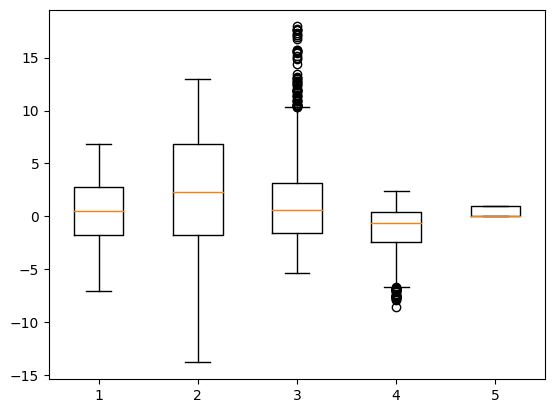

In [11]:
plt.boxplot(notes)
plt.show()

There seems to be outliers in curtosis and entropy columns, we will handle them

In [12]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [16]:
find_outliers_IQR(notes['curtosis'])

765     15.6824
780     13.1779
815     10.7402
816     10.9818
820     17.6772
821     12.4547
826     14.9704
841     12.7957
877     10.3846
881     17.3087
882     11.9655
887     15.5573
902     11.9149
937     11.8318
938     10.9390
942     17.9274
943     11.3897
948     14.3689
949     10.4403
963     13.0545
998     10.5405
999     11.3880
1003    16.9583
1004    12.3630
1009    14.8881
1024    11.9552
1059    11.6433
1060    10.4052
1064    17.5795
1065    10.5234
1070    15.6773
1085    12.6689
1120    11.8678
1121    10.9690
1125    17.6052
1126    11.4419
1131    15.6199
1132    10.3315
1146    12.9817
1181    10.5251
1182    11.2440
1186    17.1116
1187    12.5550
1192    15.6559
1207    12.7957
1243    10.4266
1247    17.0834
1248    12.1291
1253    15.4417
1268    13.0597
1304    10.3332
1308    16.7166
1309    11.8387
1314    15.1606
1329    13.4727
1364    10.4849
1365    10.8867
1369    17.5932
1370    12.3930
Name: curtosis, dtype: float64

In [19]:
find_outliers_IQR(notes['entropy'])

41     -6.8103
45     -7.5034
47     -7.5034
59     -7.0495
139    -6.8103
194    -7.5836
202    -7.5034
291    -7.7853
341    -6.8194
394    -7.7581
465    -8.5482
529    -7.5487
543    -7.1025
562    -7.6418
581    -7.8719
606    -6.9978
615    -6.8103
740    -7.6612
776    -6.6797
791    -6.7754
837    -7.0107
852    -6.9590
898    -6.8607
974    -7.5034
1142   -7.5344
1157   -7.3004
1164   -6.7844
1203   -7.5887
1218   -7.5642
1225   -6.9642
1264   -7.5887
1279   -7.3987
1286   -6.8517
Name: entropy, dtype: float64

In [17]:
def cap_Outliers(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    lowbound = q1 -(1.5*IQR)
    upbound = q3 +(1.5*IQR)
    df = df.apply(lambda x : lowbound if x < lowbound  else  upbound  if x > upbound else x)
    return df

In [23]:
notes['curtosis'] = cap_Outliers(notes['curtosis'])
notes['entropy'] = cap_Outliers(notes['entropy'])


In [24]:
find_outliers_IQR(notes['entropy'])

Series([], Name: entropy, dtype: float64)

In [25]:
find_outliers_IQR(notes['curtosis'])

Series([], Name: curtosis, dtype: float64)

All the outliers have been capped

In [36]:
X = notes[['variance','skewness','curtosis','entropy']]
y = notes['class']

In [38]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [39]:
x_train.shape,x_test.shape,len(y_train),len(y_test)

((1097, 4), (275, 4), 1097, 275)

In [40]:
std=StandardScaler()
x_train=std.fit_transform(x_train)
x_test=std.transform(x_test)

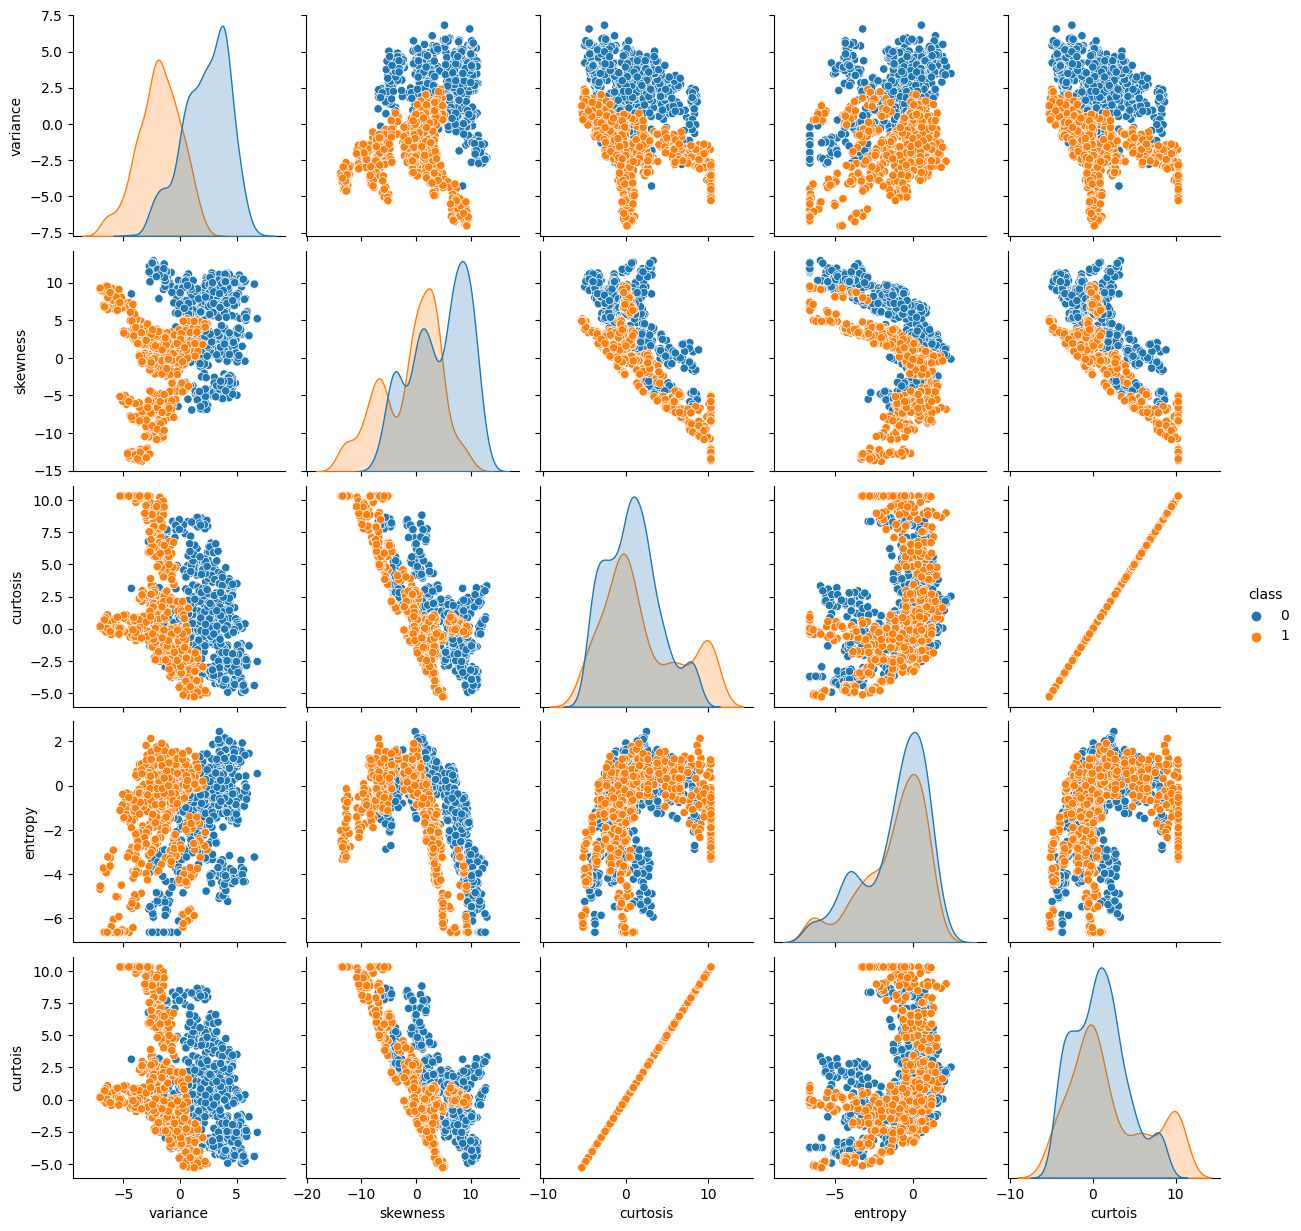

In [57]:
sns.pairplot(notes,hue='class')
plt.show()

In [60]:
# use both Int and Choice
def tuners(hp):
    model = Sequential()
    count = 0
    for y in range(hp.Int("no.of hidden layers",1,5)):
        if count == 0:
              model.add(Dense(units=(hp.Int("neurons{}".format(y),3,10)),activation= hp.Choice("activation in {} hidden layer".format(y),values=['sigmoid','tanh','relu']),
                            kernel_initializer=hp.Choice("Initializer in {} hidden layer".format(y),values=['glorot_uniform','glorot_normal','he_uniform','he_normal'])
                            ,input_dim=4))
        else:
              model.add(Dense(units=(hp.Int("neurons{}".format(y),1,10)),activation= hp.Choice("activation in {} hidden layer".format(y),values=['sigmoid','tanh','relu']),
                            kernel_initializer=hp.Choice("Initializer in {} hidden layer".format(y),values=['glorot_uniform','glorot_normal','he_uniform','he_normal'])
                            ))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=hp.Choice("optimizer",values=['adam','adadelta','sgd']) ,metrics=['accuracy'])
    return model



In [61]:
tuner_obj = k.RandomSearch(tuners,max_trials=10,objective='val_accuracy',directory='folder')

In [62]:
tuner_obj

In [63]:
es = EarlyStopping(monitor='val_accuracy',min_delta=0.1,patience=3,verbose=1)

In [64]:
tuner_obj.search(x_train,y_train,batch_size=100,epochs=50,validation_split=0.2,callbacks=[es]) # here actual training starts

Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.7772727012634277

Best val_accuracy So Far: 0.8409090638160706
Total elapsed time: 00h 00m 29s


In [65]:
tuner_obj.results_summary()

Results summary
Results in folder/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
no.of hidden layers: 4
neurons0: 7
activation in 0 hidden layer: relu
Initializer in 0 hidden layer: glorot_normal
optimizer: adam
neurons1: 7
activation in 1 hidden layer: relu
Initializer in 1 hidden layer: he_normal
neurons2: 10
activation in 2 hidden layer: relu
Initializer in 2 hidden layer: glorot_normal
neurons3: 7
activation in 3 hidden layer: tanh
Initializer in 3 hidden layer: glorot_normal
neurons4: 7
activation in 4 hidden layer: sigmoid
Initializer in 4 hidden layer: he_uniform
Score: 0.8409090638160706

Trial 09 summary
Hyperparameters:
no.of hidden layers: 2
neurons0: 9
activation in 0 hidden layer: tanh
Initializer in 0 hidden layer: glorot_normal
optimizer: adam
neurons1: 6
activation in 1 hidden layer: relu
Initializer in 1 hidden layer: glorot_uniform
neurons2: 7
activation in 2 hidden layer: relu
Initializer in 

In [66]:
tuner_obj.get_best_hyperparameters()[0].values

{'no.of hidden layers': 4,
 'neurons0': 7,
 'activation in 0 hidden layer': 'relu',
 'Initializer in 0 hidden layer': 'glorot_normal',
 'optimizer': 'adam',
 'neurons1': 7,
 'activation in 1 hidden layer': 'relu',
 'Initializer in 1 hidden layer': 'he_normal',
 'neurons2': 10,
 'activation in 2 hidden layer': 'relu',
 'Initializer in 2 hidden layer': 'glorot_normal',
 'neurons3': 7,
 'activation in 3 hidden layer': 'tanh',
 'Initializer in 3 hidden layer': 'glorot_normal',
 'neurons4': 7,
 'activation in 4 hidden layer': 'sigmoid',
 'Initializer in 4 hidden layer': 'he_uniform'}

In [67]:
model = tuner_obj.get_best_models(num_models=1)[0]

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 35        
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
 dense_2 (Dense)             (None, 10)                80        
                                                                 
 dense_3 (Dense)             (None, 7)                 77        
                                                                 
 dense_4 (Dense)             (None, 1)                 8         
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


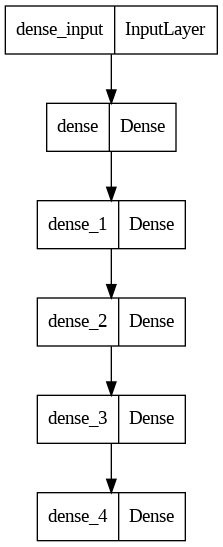

In [69]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [70]:
history = model.fit(x_train,y_train,epochs=20,validation_split=0.2)

Epoch 1/20
28/28 [==============================] - 4s 25ms/step - loss: 0.5820 - accuracy: 0.8426 - val_loss: 0.5369 - val_accuracy: 0.8682
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.4939 - accuracy: 0.8883 - val_loss: 0.4358 - val_accuracy: 0.9136
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.3867 - accuracy: 0.9190 - val_loss: 0.3168 - val_accuracy: 0.9364
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.2754 - accuracy: 0.9441 - val_loss: 0.2107 - val_accuracy: 0.9682
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1862 - accuracy: 0.9635 - val_loss: 0.1369 - val_accuracy: 0.9909
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1262 - accuracy: 0.9795 - val_loss: 0.0907 - val_accuracy: 0.9955
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0927 - accuracy: 0.9829 - val_loss: 0.0640 - val_accuracy: 0.9955
Epoch 8/20
28/28 [

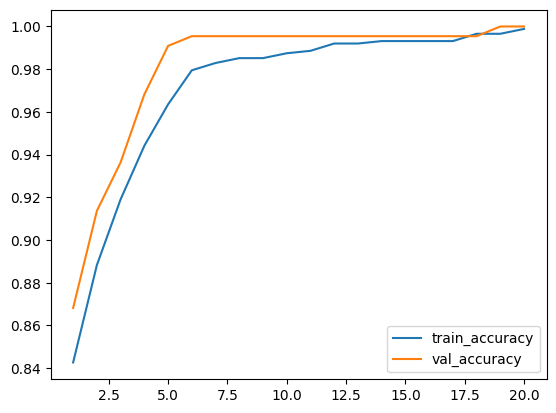

In [71]:
plt.plot(range(1,21),history.history["accuracy"],label="train_accuracy")
plt.plot(range(1,21),history.history["val_accuracy"],label="val_accuracy")
plt.legend()